In [72]:
import os
import numpy as np
from collections import defaultdict

import sys

sys.path.append("../2_train_models")
from data_loading import extract_peaks
from file_configs import MergedFilesConfig

sys.path.append("../5_modisco")
from modiscolite_utils import load_observed_profiles

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23]

# This is specific to K562

motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

In [15]:
cell_type = "K562"
model_type = "strand_merged_umap"
data_type = "procap"


timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

in_window = 2114
out_window = 1000

proj_dir = os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd()))) + "/"

figures_dir = proj_dir + "figures/"

In [4]:
config = MergedFilesConfig(cell_type, model_type, data_type)

genome_path = config.genome_path
chrom_sizes = config.chrom_sizes

slice_len = config.slice

peak_path = config.all_peak_path

modisco_results_path = config.modisco_profile_results_path

scores_path = config.profile_onehot_scores_path

In [5]:
config.__dict__

{'cell_type': 'K562',
 'model_type': 'strand_merged_umap',
 'data_type': 'procap',
 'stranded_model': False,
 'umap': True,
 'proj_dir': '/mnt/lab_data2/kcochran/procapnet/',
 'genome_path': '/mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta',
 'chrom_sizes': '/mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.chrom.sizes',
 'mask_bw_path': '/mnt/lab_data2/kcochran/procapnet//annotations/hg38.k36.multiread.umap.bigWig',
 'data_dir': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/',
 'all_peak_path': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz',
 'plus_bw_path': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/5prime.pos.bigWig',
 'minus_bw_path': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/5prime.neg.bigWig',
 'slice': 1000,
 'pred_profiles_all_path': '/mnt/lab_data2/kcochran/procapnet/model_out/procap/K562/strand_merged_umap/merged/all_pred_profiles.npy',
 'pred_logcounts_all_path': '/mnt/lab

In [6]:
from motif_hits_utils import load_coords

coords = load_coords(peak_path, in_window=in_window)

In [7]:
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed

ccre_bed = get_ccre_bed(cell_type, proj_dir)

ccre_annots = find_peak_overlap_labels(coords, ccre_bed, in_window, out_window)

In [8]:
ccre_annots["PLS_no_pELS"] = ccre_annots["PLS"] * (~ ccre_annots["pELS"])
ccre_annots["PLS_with_pELS"] = ccre_annots["PLS"] * ccre_annots["pELS"]

In [10]:
onehot_seqs, true_profs = extract_peaks(genome_path,
                                        chrom_sizes,
                                        config.plus_bw_path,
                                        config.minus_bw_path,
                                        peak_path,
                                        in_window=in_window,
                                        out_window=out_window,
                                        max_jitter=0,
                                        verbose=True)

#scores = load_scores(scores_path,
#                     slice_len=slice_len,
#                     in_window=in_window)

true_counts = true_profs.sum(axis=(1,2))  # strand-merged

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.96it/s]
Loading Peaks: 30534it [00:48, 625.43it/s]


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 30534
Mask loaded? False


In [11]:
pred_profs = np.exp(np.load(config.pred_profiles_all_path))
pred_counts = np.exp(np.load(config.pred_logcounts_all_path)).squeeze()

PLS_with_pELS
Pred. vs. Obs. MSE: 0.47791216
Pred vs. Obs Pearson r: 0.5562999411785335

PLS_no_pELS
Pred. vs. Obs. MSE: 1.0471153
Pred vs. Obs Pearson r: 0.4922346725043387

dELS
Pred. vs. Obs. MSE: 0.77228284
Pred vs. Obs Pearson r: 0.6449231985337881



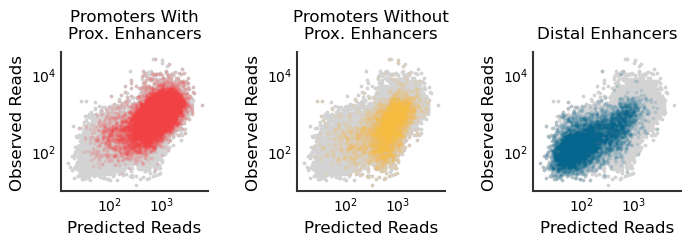

In [21]:
def plot_true_pred_counts_by_annot(true_counts, pred_counts, overlap_annots_bools,
                                   save_path = None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers",
                        "PLS_with_pELS" : "Promoters With\nProx. Enhancers",
                        "PLS_no_pELS" : "Promoters Without\nProx. Enhancers" }
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d",
                        "PLS_with_pELS" : "#f94144",
                        "PLS_no_pELS" : "#ffbc42"}
    
    fig, axes = plt.subplots(1,3,figsize=(8,1.8))
    
    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"] #["PLS", "pELS", "dELS"]
    
    all_x = []
    all_y = []
    for annot_name in annots_to_plot:
        all_x.extend(pred_counts[overlap_annots_bools[annot_name]])
        all_y.extend(true_counts[overlap_annots_bools[annot_name]])
    
    for ax, sup_annot_name in zip(axes, annots_to_plot):
        ax.scatter(all_x, all_y, alpha = 1, s = 3,
                    label = "Other", color = "lightgray")
        
        # have to plot last
        true_counts_subset = true_counts[overlap_annots_bools[sup_annot_name]]
        pred_counts_subset = pred_counts[overlap_annots_bools[sup_annot_name]]
        
        mse = np.mean((np.log1p(pred_counts_subset) - np.log1p(true_counts_subset)) ** 2)
        print(sup_annot_name)
        print("Pred. vs. Obs. MSE:", mse)
        print("Pred vs. Obs Pearson r:", np.corrcoef(np.log1p(pred_counts_subset), np.log1p(true_counts_subset))[0,1])
        print("")
        
        ax.scatter(pred_counts_subset, true_counts_subset, alpha = 0.1, s = 3,
                    label = annots_to_labels[sup_annot_name],
                    color = annots_to_colors[sup_annot_name])

        ax.semilogy()
        ax.semilogx()

        ax.set_xlabel("Predicted Reads", fontsize = 12)
        ax.set_ylabel("Observed Reads", fontsize = 12)

        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(axis='both', labelsize=10, length=0)
        
        ax.set_title(annots_to_labels[sup_annot_name], fontsize=12, pad=10)

    plt.subplots_adjust(wspace=0.6)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()

    
plot_true_pred_counts_by_annot(true_counts, pred_counts, ccre_annots,
                               save_path = figures_dir + "S1E_counts_by_ccre.png")

In [13]:
mse = np.mean((np.log1p(pred_counts) - np.log1p(true_counts)) ** 2)
mse

0.74069697

In [14]:
mse = np.mean((np.log1p(pred_counts[ccre_annots["PLS"]]) - np.log1p(true_counts[ccre_annots["PLS"]])) ** 2)
mse

0.58799386

In [17]:
from BPNet_strand_merged_umap import Model
import torch

# re-define the model's forward func so that it returns output of intermediate layer

class BPNet_Embeddings_Loader(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming

        X = self.relus[0](self.iconv(X))

        for i in range(self.n_layers):
            X_conv = self.relus[i+1](self.rconvs[i](X))
            X = torch.add(X, X_conv)
            
        X = X[:, :, start - self.deconv_kernel_size//2 : end + self.deconv_kernel_size//2]

        # return result of global avg pooling
        # (beginning of counts head, before linear layer)
        X = torch.mean(X, axis=2)
        return X
    
    
def get_embeddings(embedder, seqs, batch_size=128):
    if not seqs.shape[-2] == 4:
        seqs = np.swapaxes(seqs, -2, -1)
    seqs = torch.tensor(seqs, dtype=torch.float)
    embedder = embedder.cuda()
    with torch.no_grad():
        starts = np.arange(0, seqs.shape[0], batch_size)
        ends = starts + batch_size

        embeds = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if i % 10 == 0:
                print("Batch " + str(i) + " of " + str(len(starts)))
            
            seqs_batch = seqs[start:end]
            embeds_batch = embedder(seqs_batch.cuda()).cpu().detach().numpy()
            embeds.append(embeds_batch)

    embedder = embedder.cpu()
    return np.concatenate(embeds)

In [19]:
# the arch-related args here have to match what was input when the model was trained

embedder = BPNet_Embeddings_Loader("_",
                                   n_filters=512,
                                   n_layers=8,
                                   trimming=(in_window - out_window) // 2,
                                   alpha=100)

from file_configs import FoldFilesConfig
model_save_path = FoldFilesConfig(cell_type, model_type, "1", timestamps[0], data_type).model_save_path

loaded_model_state = torch.load(model_save_path).state_dict()
embedder.load_state_dict(loaded_model_state)

Timestamp: 2023-05-29_15-51-40


<All keys matched successfully>

In [20]:
embedder

BPNet_Embeddings_Loader(
  (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
  (rconvs): ModuleList(
    (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (fconv): Conv1d(512, 2, kernel_size=(75,), stride=(1,))
  (relus): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): ReLU()
    (5): Re

In [12]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-40f43250-998e-586a-ac37-d6520e92590f"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

# TODO: need to re-run (didn't have a free GPU)

embedder.eval()
embedder = embedder.cuda()

In [13]:
peak_embeds = get_embeddings(embedder, onehot_seqs)

Batch 0 of 211
Batch 10 of 211
Batch 20 of 211
Batch 30 of 211
Batch 40 of 211
Batch 50 of 211
Batch 60 of 211
Batch 70 of 211
Batch 80 of 211
Batch 90 of 211
Batch 100 of 211
Batch 110 of 211
Batch 120 of 211
Batch 130 of 211
Batch 140 of 211
Batch 150 of 211
Batch 160 of 211
Batch 170 of 211
Batch 180 of 211
Batch 190 of 211
Batch 200 of 211
Batch 210 of 211


In [14]:
peak_embeds

array([[0.00793863, 0.03003851, 0.02376998, ..., 0.01035993, 0.14091788,
        0.06037785],
       [0.01115191, 0.03345607, 0.02252001, ..., 0.0135703 , 0.14266135,
        0.05017686],
       [0.01419436, 0.02334539, 0.04809463, ..., 0.03943525, 0.12689619,
        0.05573117],
       ...,
       [0.01383179, 0.01757896, 0.05491781, ..., 0.03251595, 0.08679914,
        0.04273102],
       [0.02027073, 0.02737194, 0.03567499, ..., 0.02237213, 0.04949317,
        0.03909505],
       [0.01546966, 0.03339285, 0.02500893, ..., 0.0104342 , 0.07282893,
        0.0373729 ]], dtype=float32)

In [15]:
promoter_embeds = peak_embeds[ccre_annots["PLS"]]
promoters_with_pELS_embeds = peak_embeds[ccre_annots["PLS"] * ccre_annots["pELS"]]
promoters_no_pELS_embeds = peak_embeds[ccre_annots["PLS"] * (~ ccre_annots["pELS"])]
d_enhancer_embeds = peak_embeds[ccre_annots["dELS"]]

print(len(promoter_embeds), len(promoters_with_pELS_embeds), len(promoters_no_pELS_embeds), len(d_enhancer_embeds))

14829 11992 2837 5097


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pcs = pca.fit(peak_embeds)
promoter_pcs = pca.transform(promoter_embeds)
d_enhancer_pcs = pca.transform(d_enhancer_embeds)
promoters_with_pELS_pcs = pca.transform(promoters_with_pELS_embeds)
promoters_no_pELS_pcs = pca.transform(promoters_no_pELS_embeds)

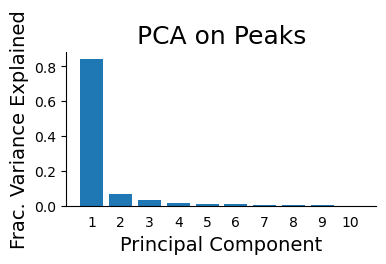

In [17]:
plt.figure(figsize=(4,2))
plt.bar(range(1, 10+1), pca.explained_variance_ratio_)
plt.xlabel("Principal Component", fontsize = 14)
plt.ylabel("Frac. Variance Explained", fontsize = 14)
plt.title("PCA on Peaks", fontsize = 18)

plt.xticks(range(1, 10+1))
for side in ["right", "top"]:
    plt.gca().spines[side].set_visible(False)
plt.gca().xaxis.set_ticks_position('none') 

plt.show()

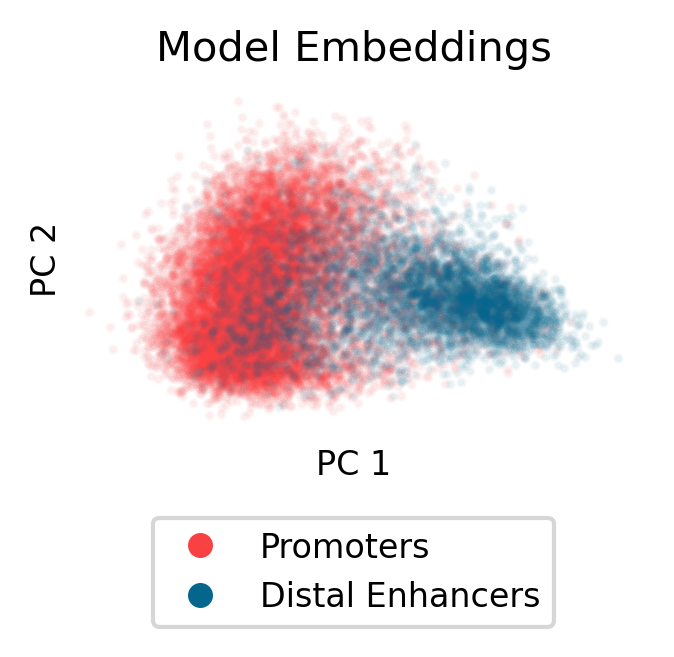

In [37]:
from matplotlib.lines import Line2D

def plot_embeds_pca(promoter_pcs, d_enhancer_pcs, save_path = None):
    plt.figure(figsize=(2.5,1.5), dpi=300)

    plt.scatter(promoter_pcs[..., 0], promoter_pcs[..., 1],
                alpha = 0.05, s = 2, c="#f94144")
    plt.scatter(d_enhancer_pcs[..., 0], d_enhancer_pcs[..., 1],
                alpha = 0.05, s = 2, c="#05668d")

    plt.xlabel("PC 1", fontsize = 8)
    plt.ylabel("PC 2", fontsize = 8, labelpad=0)
    plt.title("Model Embeddings", fontsize = 10)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)


    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Promoters',
                              markerfacecolor="#f94144", markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Distal Enhancers',
                              markerfacecolor="#05668d", markersize=7)]

    plt.legend(handles=legend_elements, fontsize = 8,
               loc='upper center', bbox_to_anchor = (0.5, -0.2))

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
plot_embeds_pca(promoter_pcs, d_enhancer_pcs, save_path = figures_dir + "3A_embeds.png")

In [34]:
def get_orientation_indexes(profiles):
    return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))

ois = get_orientation_indexes(true_profs)

In [35]:
def inverse_hist(profile):
    assert len(profile.shape) == 1 or (len(profile.shape) == 2 and profile.shape[0] == 2), profile.shape

    profile = profile.sum(axis=0).astype(int)
    return np.repeat(range(len(profile)), profile)

def get_variances(profiles):
    return np.array([np.var(inverse_hist(profile)) for profile in profiles])

variances = get_variances(true_profs)

In [36]:
promoter_ois = ois[ccre_annots["PLS"]]
p_enhancer_ois = ois[ccre_annots["pELS"]]
d_enhancer_ois = ois[ccre_annots["dELS"]]

In [37]:
promoter_vars = variances[ccre_annots["PLS"]]
p_enhancer_vars = variances[ccre_annots["pELS"]]
d_enhancer_vars = variances[ccre_annots["dELS"]]

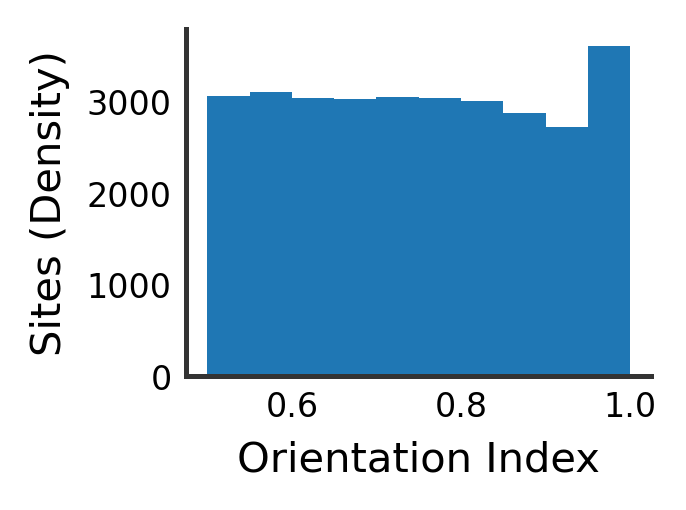

In [38]:
plt.figure(figsize=(2,1.5), dpi=300)

plt.hist(ois)

plt.xlabel("Orientation Index", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

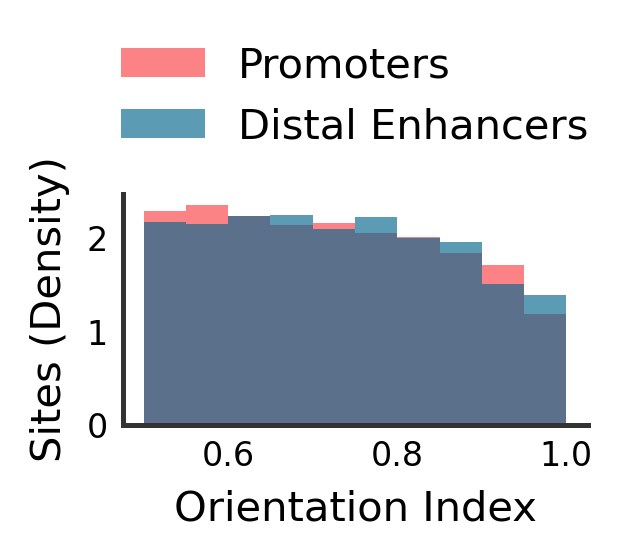

In [39]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(promoter_ois, density=True, alpha=0.65, label="Promoters", color="#f94144")
plt.hist(d_enhancer_ois, density=True, alpha=0.65, label="Distal Enhancers", color="#05668d")

plt.xlabel("Orientation Index", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

In [42]:
from common_functions import get_norm_shannon_entropies

norm_shannon_entropies = get_norm_shannon_entropies(true_profs, true_counts)
promoter_nses = norm_shannon_entropies[ccre_annots["PLS"]]
enhancer_nses = norm_shannon_entropies[ccre_annots["dELS"]]

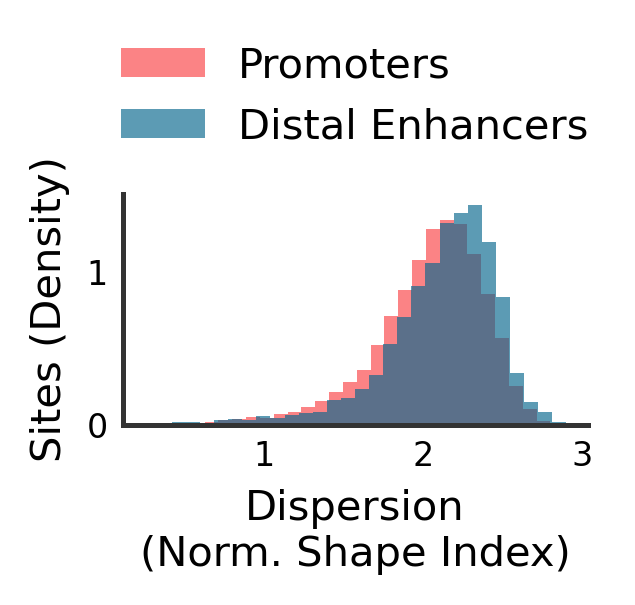

In [43]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(promoter_nses, density=True, alpha=0.65, label="Promoters", color="#f94144", bins=30)
plt.hist(enhancer_nses, density=True, alpha=0.65, label="Distal Enhancers", color="#05668d", bins=30)

plt.xlabel("Dispersion\n(Norm. Shape Index)", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

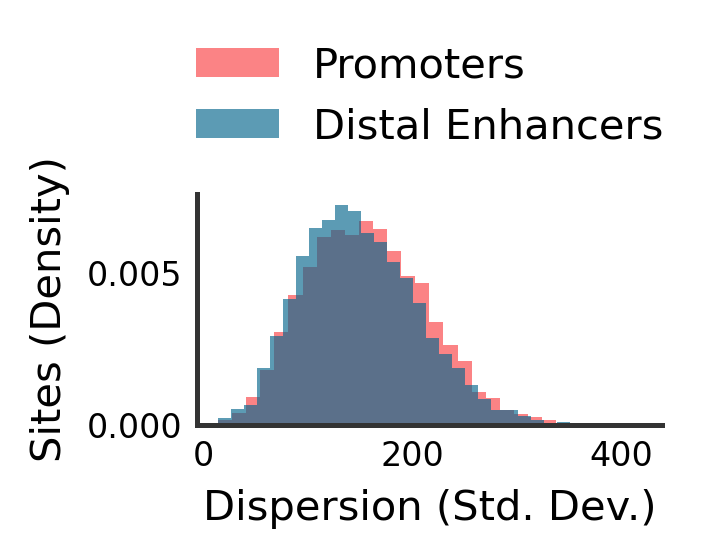

In [44]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(np.sqrt(promoter_vars), density=True, alpha=0.65, label="Promoters", color="#f94144", bins=30)
plt.hist(np.sqrt(d_enhancer_vars), density=True, alpha=0.65, label="Distal Enhancers", color="#05668d", bins=30)

plt.xlabel("Dispersion (Std. Dev.)", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

In [166]:
from matplotlib import colormaps as cmaps

def plot_embeds_pca_with_ois(promoter_pcs, d_enhancer_pcs, promoter_ois, d_enhancer_ois):
    plt.figure(figsize=(6,3))

    cmap = cmaps["viridis"]
    plt.scatter(promoter_pcs[..., 0], promoter_pcs[..., 1],
                alpha = 0.2, s = 7, c=promoter_ois, cmap=cmap)
    plt.scatter(d_enhancer_pcs[..., 0], d_enhancer_pcs[..., 1],
                alpha = 0.2, s = 7, c=d_enhancer_ois, cmap=cmap)
    

    plt.xlabel("PC 1", fontsize = 16)
    plt.ylabel("PC 2", fontsize = 16)
    plt.title("Peak Embeddings", fontsize = 20)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)

    plt.colorbar()

    plt.show()
    
plot_embeds_pca_with_ois(promoter_pcs, d_enhancer_pcs, promoter_ois, d_enhancer_ois)

NameError: name 'promoter_pcs' is not defined

In [165]:
from matplotlib import colormaps as cmaps

def plot_embeds_pca_with_ois(peak_pcs, ois):
    plt.figure(figsize=(6,3))

    cmap = cmaps["viridis"]
    plt.scatter(peak_pcs[..., 0], peak_pcs[..., 1],
                alpha = 0.2, s = 7, c=ois, cmap=cmap)
    

    plt.xlabel("PC 1", fontsize = 16)
    plt.ylabel("PC 2", fontsize = 16)
    plt.title("Peak Embeddings", fontsize = 20)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)

    plt.colorbar()

    plt.show()
    
plot_embeds_pca_with_ois(peak_pcs, ois)

NameError: name 'peak_pcs' is not defined

In [68]:
### Load Motifs

from motif_hits_utils import load_motif_hits

motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, data_type,
                                                                 in_window=in_window)

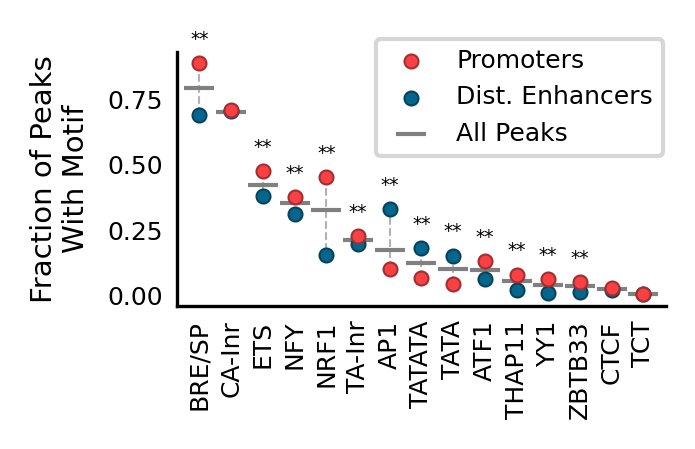

In [73]:
from collections import defaultdict
import scipy
import scipy.stats

def perm_test_diff_motif_fracs(pls_motifs, dels_motifs):
    return np.mean(pls_motifs) - np.mean(dels_motifs)



def plot_motif_enrichment_in_cCREs_condensed(peak_hit_counts, overlap_annots_bools,
                                        annots_to_plot = ["PLS", "dELS"],
                                        motif_keys_to_labels = motif_names,
                                            save_path = None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Dist. Enhancers"}
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}
    annots_to_edgecolors = {"All Peaks" : "gray", "PLS" : "#A12F31", "dELS" : "#05435C"}
    annots_to_sizes = {"All Peaks" : 50, "PLS" : 45, "dELS" : 45}
    
    annot_vals = defaultdict(lambda : [])
    pvals = []
    
    assert len(motif_keys_to_labels) == peak_hit_counts.shape[1]
    
    motif_keys = range(len(motif_keys_to_labels))
    for motif_index in motif_keys:
        total_peaks_with_motif = np.sum(peak_hit_counts[:, motif_index] > 0)

        for key in annots_to_plot:
            overlap_peaks = np.sum(overlap_annots_bools[key])
            overlap_peaks_with_motif = np.sum(peak_hit_counts[overlap_annots_bools[key], motif_index] > 0)

            annot_vals[key].append(overlap_peaks_with_motif / overlap_peaks)
            
        # sorry hardcoding it
        mwu_pval = scipy.stats.permutation_test((peak_hit_counts[ccre_annots["PLS"], motif_index],
                                                 peak_hit_counts[ccre_annots["dELS"], motif_index]),
                                                perm_test_diff_motif_fracs, n_resamples=9999).pvalue
        
        if mwu_pval <= 2e-4:
            pvals.append("**")
        elif mwu_pval < 0.01:
            pvals.append("*")
        else:
            pvals.append(" ")
            
        annot_vals["All Peaks"].append(total_peaks_with_motif / peak_hit_counts.shape[0])

    plot_order = np.argsort(annot_vals["All Peaks"])[::-1]
        
    plt.figure(figsize=(2.1, 1.1), dpi=300)
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        plt.plot([y] * 2,
                 [annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]],
                 color="gray", alpha = 0.6, linewidth=0.5, linestyle="dashed")
        
        plt.text(y, 0.07 + max(annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]),
                 pvals[plot_i],
                 fontsize=4.5, horizontalalignment="center")
        
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Peaks":
                plt.scatter(y, vals[plot_i],
                            label=key if add_to_legend else "",
                            color=annots_to_colors[key],
                            linewidth=1,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker="_")
            else:
                plt.scatter(y, vals[plot_i],
                            label=annots_to_labels[key] if add_to_legend else "",
                            color=annots_to_colors[key],
                            edgecolor=annots_to_edgecolors[key],
                            linewidth=0.5,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="upper right", bbox_to_anchor=(1.02, 1.1))
    plt.xticks(motif_keys, np.array(motif_keys_to_labels)[plot_order],
               fontsize=6, rotation=90)
    plt.tick_params(left=False, length=0)
    plt.yticks([0.0, 0.25, 0.5, 0.75], fontsize=6)
    plt.ylabel("Fraction of Peaks\nWith Motif", fontsize=7)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts["profile"], ccre_annots,
                                        save_path = figures_dir + "3C_ccre_motif_fracs.png")

In [36]:
np.sum(ccre_annots["PLS"]), np.sum(ccre_annots["dELS"]), np.sum(np.logical_or(ccre_annots["PLS"], ccre_annots["dELS"]))


(16960, 5648, 22608)

In [37]:
from sklearn.linear_model import LogisticRegression

tmp_data_idxs = np.logical_or(ccre_annots["PLS"], ccre_annots["dELS"])
tmp_X = motif_hit_counts["profile"][tmp_data_idxs]
tmp_y = ccre_annots["PLS"][tmp_data_idxs]

lrm = LogisticRegression(penalty='none').fit(tmp_X, tmp_y)

# accuracy of LR classifier on promoter vs. enhancer
print(lrm.score(tmp_X, tmp_y))

0.8190021231422505


In [38]:
for motif_i, motif_name in enumerate(motif_names):
    print(motif_name, "%0.3f" % (lrm.coef_.squeeze()[motif_i]))

BRE/SP 0.317
CA-Inr 0.112
ETS 0.419
NFY 0.370
NRF1 0.907
ATF1 0.760
TATA -0.723
THAP11 1.259
YY1 1.872
AP1 -0.880
TA-Inr 0.148
CTCF 0.024
ZBTB33 1.364
TCT 0.522
TATATA -0.523


In [39]:
lrm2 = LogisticRegression(penalty='none').fit(tmp_X > 0, tmp_y)

# accuracy of LR classifier on promoter vs. enhancer
print(lrm2.score(tmp_X > 0, tmp_y))

for motif_i, motif_name in enumerate(motif_names):
    print(motif_name, "%0.3f" % (lrm2.coef_.squeeze()[motif_i]))

0.8003361641896674
BRE/SP 1.148
CA-Inr 0.087
ETS 0.415
NFY 0.431
NRF1 1.327
ATF1 0.743
TATA -0.964
THAP11 1.512
YY1 2.021
AP1 -1.159
TA-Inr 0.139
CTCF 0.068
ZBTB33 1.468
TCT 0.600
TATATA -0.701


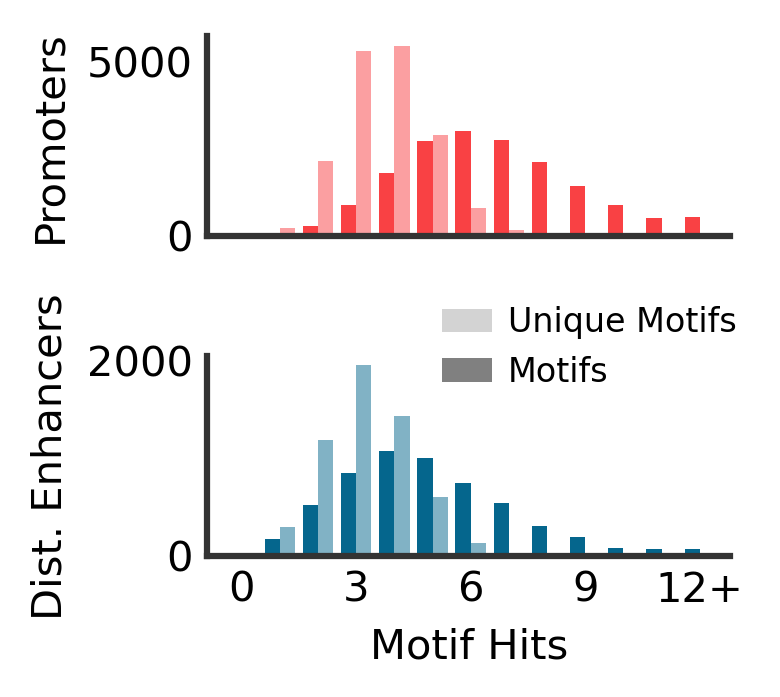

In [40]:
from matplotlib.patches import Patch


def plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots, annots_to_plot = ["PLS", "dELS"],
                                      save_path = None):
    bar_width = 0.4
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Dist. Enhancers"}
    
    
    fig, axes = plt.subplots(2, 1, figsize=(2.25,2.25), dpi=300, sharex=True)
    fig.subplots_adjust(hspace=0.6)
    
    for ax_i, key in enumerate(annots_to_plot):
        motif_hit_counts_annot = motif_hit_counts[ccre_annots[key]]
        
        # total motif hits
        
        motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

        stop_point = 12
        hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
        hist_x = list(hist_x[:stop_point]) + [stop_point]

        uniq_hits_per_peak = (motif_hit_counts_annot > 0).sum(axis=1)

        hist_y2, hist_x2 = np.histogram(uniq_hits_per_peak, bins=range(np.max(uniq_hits_per_peak) + 2))
        
        
        
        axes[ax_i].bar(hist_x, hist_y, color=annots_to_colors[key], width=bar_width)
        axes[ax_i].bar(hist_x2[:-1] + bar_width, hist_y2, color=annots_to_colors[key], width=bar_width, alpha=0.5)

        
        axes[ax_i].set_ylabel(annots_to_labels[key], fontsize=10)
        
        if ax_i == len(annots_to_plot) - 1:
            axes[ax_i].set_xlabel("Motif Hits", fontsize=10)
        
            xticklabels = []
            for i in hist_x:
                if i < stop_point:
                    xticklabels.append(str(i))
                else:
                    xticklabels.append(str(stop_point) + "+")

            axes[ax_i].set_xticks(np.array(hist_x[::3]) + bar_width / 2, xticklabels[::3])
            axes[ax_i].set_xlim(-0.7, len(hist_x))
            
        axes[ax_i].tick_params("both", length=0)

        axes[ax_i].spines[["left", "bottom"]].set_linewidth(1.5)
        axes[ax_i].spines[["left", "bottom"]].set_color("#333333")
        axes[ax_i].spines[["top", "right"]].set_visible(False)


    legend_elements = [Patch(facecolor='lightgray', label='Unique Motifs'),
                       Patch(facecolor='gray', label='Motifs')]

    axes[-1].legend(handles=legend_elements, fontsize=8, bbox_to_anchor=(0,0,1.07,1.4),
                   loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
            
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()


plot_motif_complexity_across_ccres(motif_hit_counts["profile"], ccre_annots,
                                  save_path = figures_dir + "3C_ccre_complexity.png")

In [42]:
scipy.stats.mannwhitneyu(motif_hit_counts["profile"][ccre_annots["PLS"]].sum(axis=-1),
                         motif_hit_counts["profile"][ccre_annots["dELS"]].sum(axis=-1)).pvalue

0.0

In [43]:
scipy.stats.mannwhitneyu((motif_hit_counts["profile"][ccre_annots["PLS"]] > 0).sum(axis=-1),
                         (motif_hit_counts["profile"][ccre_annots["dELS"]] > 0).sum(axis=-1)).pvalue

8.104330501947292e-142

In [70]:
from data_loading import one_hot_encode
from modiscolite_utils import load_sequences

onehot_seqs = load_sequences(genome_path,
                             chrom_sizes,
                             peak_path,
                             slice_len=slice_len,
                             in_window=in_window)

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length: 2114
Num. Examples: 30534


In [71]:
from report_utils import load_modisco_results, compute_per_position_ic
from other_motif_utils import trim_motif_by_ic
from other_motif_utils import trim_motif_by_thresh

from matplotlib.patches import Patch


def score_seq_by_cwm(cwm, seq):
    if type(seq) == str:
        seq = one_hot_encode(seq)
    return np.multiply(seq, cwm).sum()


def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 200):
        
    assert len(onehot_seqs.shape) == 3 and onehot_seqs.shape[1] == 4, onehot_seqs.shape
    
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[-1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))

        return np.array(real_starts), np.array(real_ends)
        
        
    
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"] - 2
    motif_ends = motif_hits["end"] + 2
    
    # if you don't want to trim at all to look more like old results
    #motif_starts = (motif_hits["start"] + motif_hits["end"]) // 2 - 15
    #motif_ends = motif_starts + 30
    
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)

    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[-1]):
            seq = onehot_seqs[coord_index, :, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    if len(motif_seqs) == 0:
        print("oh no")
        return np.array([])
    
    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


def calc_motif_strengths(modisco_results_path, onehot_seqs, patterns_to_keep,
                         motif_hits, coords, in_window, prof_width=200):

    modisco_results = load_modisco_results(modisco_results_path)
    
    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_list = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # OLD:
        # need to trim here because the hit caller trimmed
        # but this just trims from 30 to 25
        #cwm_trimmed = trim_motif_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])
        
        # w new hit caller
        cwm_trimmed = trim_motif_by_thresh(pattern["contrib_scores"][:], trim_threshold=0.2, pad=2)
        cwm_trimmed = cwm_trimmed / np.sum(cwm_trimmed)
        
        
        # if you don't want to trim at all to look more like old results:
        #cwm_trimmed = pattern["contrib_scores"][:] / np.sum(pattern["contrib_scores"][:])
        
        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["motif_index"] == ax_row_i]
        
        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)

        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq.T) for seq in motif_seqs])
        cwm_score_list.append(seq_scores)
        
    return cwm_score_list


def subset_motif_hits_by_ccre(motif_hits, ccre_bools):
    peak_indexes_with_ccre = np.where(ccre_bools)[0]
    return motif_hits[motif_hits["peak_index"].isin(peak_indexes_with_ccre)]


def make_violinplot_halved(violinplot, color, left=False):
    for b in violinplot['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        
        if left:
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], - np.inf, m)
        else:
            # modify the paths to not go further left than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor(color)
        b.set_facecolor(color)
        b.set_alpha(1)
        b.set_linewidth(0.5)
        
        
def plot_motif_strengths_by_ccre(modisco_results_path, onehot_seqs,
                                 patterns_to_keep, motif_hits, coords,
                                 in_window, ccre_annots, save_path=None):
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    all_motif_strengths = dict()
    median_motif_strengths = dict()
    
    for annot in ["PLS", "dELS"]:
        motif_hits_for_annot = subset_motif_hits_by_ccre(motif_hits, ccre_annots[annot])

        motif_strengths = calc_motif_strengths(modisco_results_path, onehot_seqs,
                                               patterns_to_keep, motif_hits_for_annot,
                                               coords, in_window)
        
        all_motif_strengths[annot] = np.array(motif_strengths, dtype=object)
        median_motif_strengths[annot] = np.array([np.median(strengths) for strengths in motif_strengths])
    
    plot_order = np.argsort(median_motif_strengths["PLS"])
    num_motifs = len(all_motif_strengths["PLS"])
    
    pvals = []
    for motif_i in range(len(all_motif_strengths["PLS"])):
        mwu_pval = scipy.stats.mannwhitneyu(all_motif_strengths["PLS"][motif_i],
                                         all_motif_strengths["dELS"][motif_i]).pvalue
        if mwu_pval < 0.0001:
            pvals.append("**")
        elif mwu_pval < 0.01:
            pvals.append("*")
        else:
            pvals.append(" ")
            
    pvals = np.array(pvals)[plot_order]
    
    plt.figure(figsize=(2.3,1.1), dpi=300)

    v2 = plt.violinplot(all_motif_strengths["dELS"][plot_order], points=500,
                       positions=np.arange(num_motifs) - 0.03,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v2, annots_to_colors["dELS"], left=True)

    plt.scatter(np.arange(num_motifs) - 0.12, median_motif_strengths["dELS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    
    v1 = plt.violinplot(all_motif_strengths["PLS"][plot_order], points=500,
                       positions=np.arange(num_motifs) + 0.02,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v1, annots_to_colors["PLS"])

    plt.scatter(np.arange(num_motifs) + 0.14, median_motif_strengths["PLS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    
    # draw pval indicators
    for i in range(len(pvals)):
        plt.text(i, plt.gca().get_ylim()[1], pvals[i],
                 fontsize=4.5, horizontalalignment="center")
    
    
    plt.ylabel("Motif Strength\n(Similarity To CWM)", fontsize=7)
    
    plt.xticks(np.arange(num_motifs), np.array(motif_names)[plot_order],
               rotation=90, fontsize=6)
    
    plt.tick_params("both", length=0)
    plt.tick_params("y", labelsize=6)
    plt.xlim(-0.7, num_motifs - 0.3)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    legend_elements = [Patch(facecolor=annots_to_colors["PLS"], label='Promoters'),
                       Patch(facecolor=annots_to_colors["dELS"], label='Dist. Enhancers')]

    plt.legend(handles=legend_elements, fontsize=6, bbox_to_anchor=(0.5, 1.03), ncol=2,
                   loc='lower center', frameon=False, handletextpad=0.5, handlelength=1.5)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        
        
plot_motif_strengths_by_ccre(modisco_results_path, onehot_seqs,
                             patterns_to_keep, motif_hits["profile"], coords,
                             in_window, ccre_annots,
                             save_path=figures_dir + "3E_ccre_motif_strengths.png")

## Motif Co-occurrence Plots

In [166]:
def get_motif_jaccard_matrix(peak_hit_counts):
    peak_hit_counts = (peak_hit_counts > 0) * 1
    num_motifs = peak_hit_counts.shape[1]
    
    jaccards = np.zeros((num_motifs, num_motifs))
    for i in range(num_motifs):
        motif_i_peak_hits = peak_hit_counts[:, i]
        for j in range(i + 1, num_motifs):
            motif_j_peak_hits = peak_hit_counts[:, j]
            
            intersection = np.dot(motif_i_peak_hits, motif_j_peak_hits)
            union = np.sum((motif_i_peak_hits + motif_j_peak_hits) > 0)
            jaccards[i, j] = intersection / union
            jaccards[j, i] = jaccards[i, j]
            
    return jaccards

def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix
    

promoter_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts["profile"][ccre_annots["PLS"]])
enhancer_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts["profile"][ccre_annots["dELS"]])
combo_jaccard_matrix = combine_two_symmetric_matrices(promoter_motif_jaccard_matrix,
                                                      enhancer_motif_jaccard_matrix)

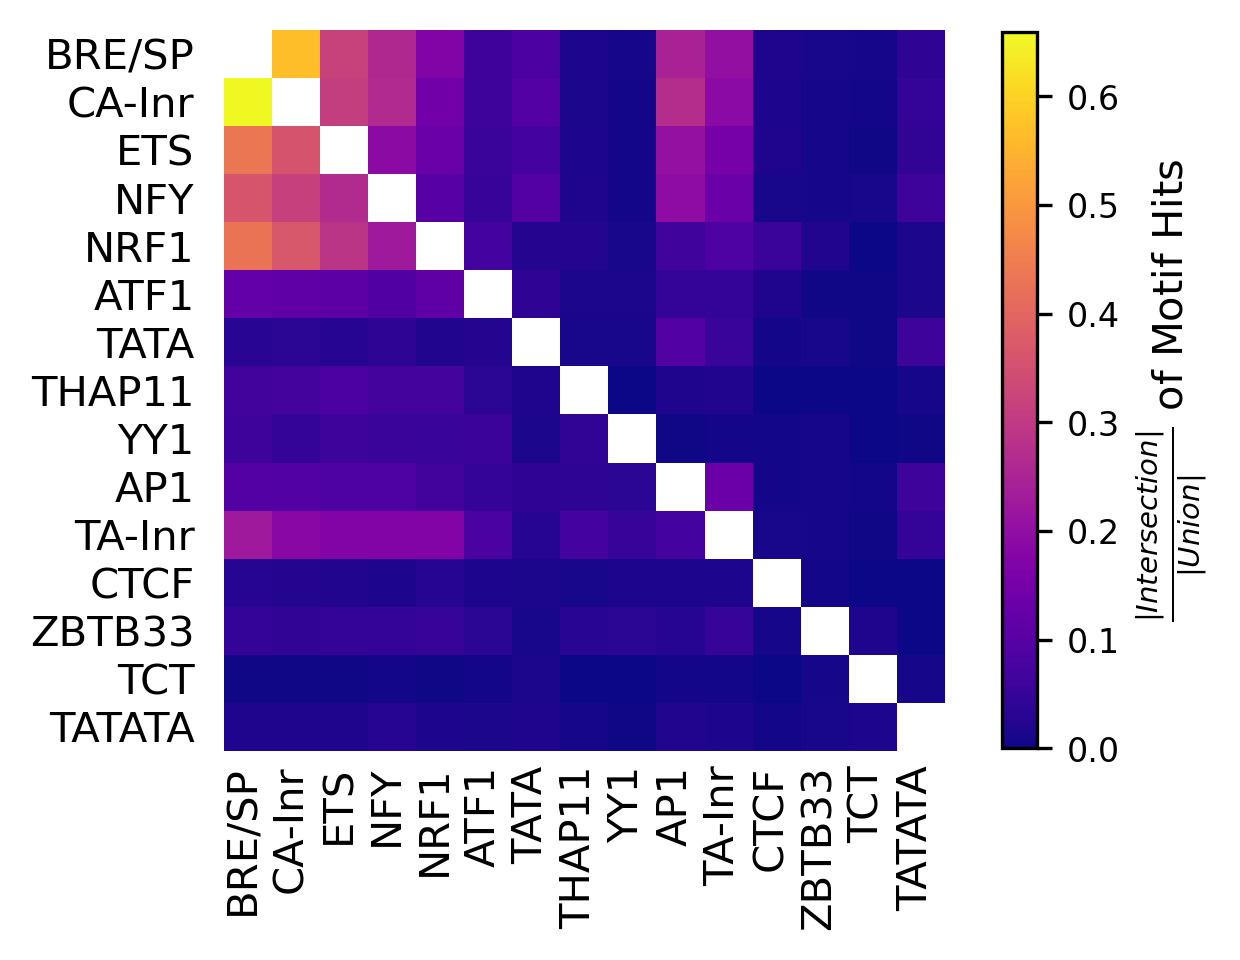

In [167]:
from plot_utils import get_continuous_cmap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def get_upper_right_highlight_coords(n_rows):
    # assuming n_rows = n_cols
    # want (5.5, 0.5), (4.5, 0.5), (4.5, 1.5), ..., (0.5, 5.5)
    
    curr_x = 0.5
    curr_y = -0.5
    
    coords_list = [(curr_x, curr_y)]
    while curr_x < n_rows - 0.5:
        curr_y += 1
        coords_list.append((curr_x, curr_y))
        curr_x += 1
        coords_list.append((curr_x, curr_y))
        
    coords_list.append((n_rows - 0.5, -0.5))
    coords_list.append(coords_list[0])  # back to start
    
    return np.array(coords_list)


def plot_jaccard_matrix(jaccard_matrix, inds=None):
    num_motifs = jaccard_matrix.shape[0]
    
    if inds is not None:
        assert len(inds) == num_motifs, inds
        jaccard_matrix = jaccard_matrix[inds][:, inds]
        ticklabels = [k + 1 for k in inds]
    else:
        ticklabels = range(num_motifs)
    
    ticklabels = [motif_names[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(jaccard_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label=r'$\frac{|Intersection|}{|Union|}$ of Motif Hits',
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_jaccard_matrix(combo_jaccard_matrix)

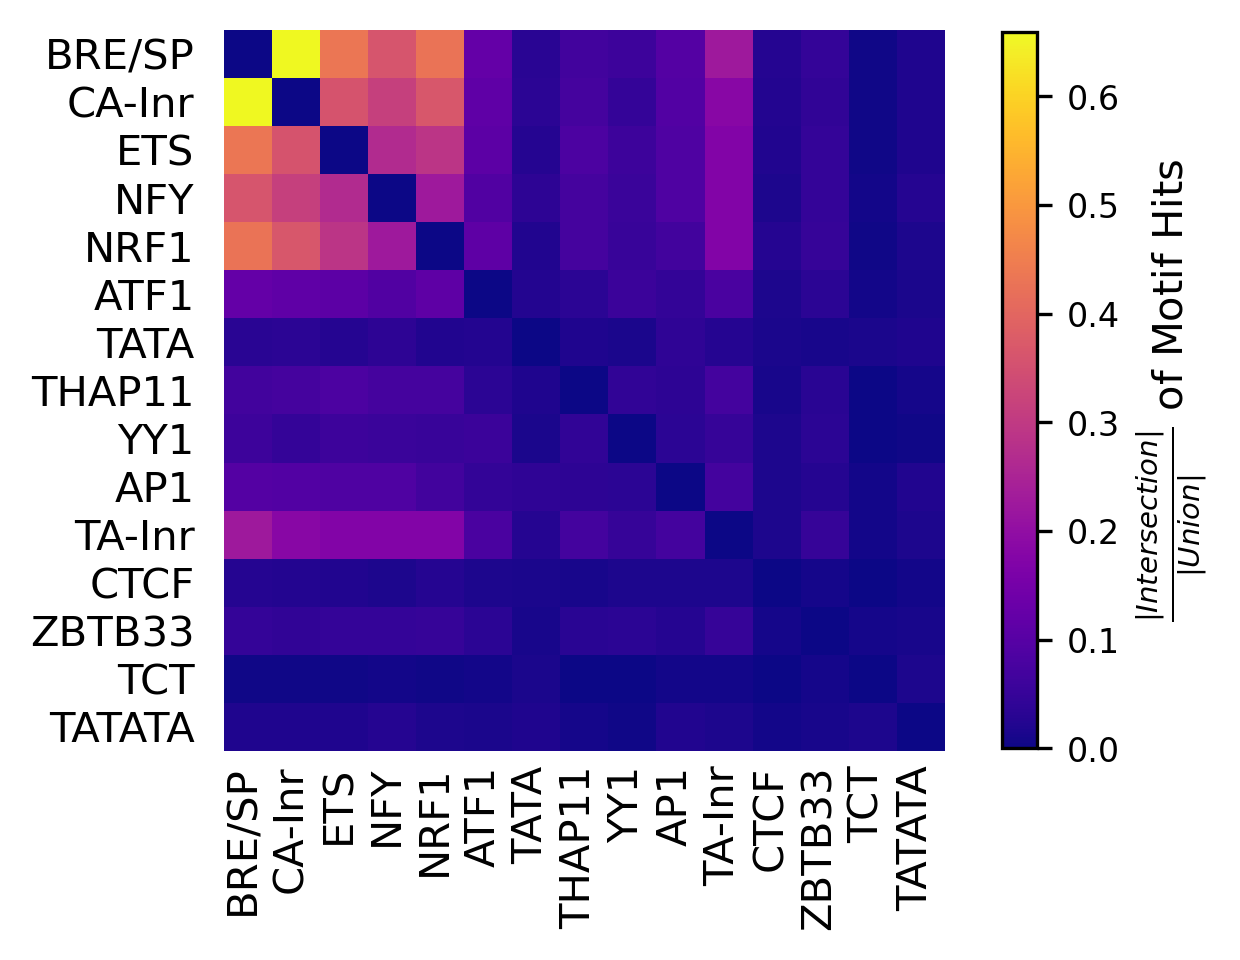

In [168]:
# sanity check which corner is the promoters corner:
plot_jaccard_matrix(promoter_motif_jaccard_matrix)

In [106]:
def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  #/ peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :]) * peak_hit_counts.shape[0] ####

    combo_matrix = combine_two_symmetric_matrices(motif_frac_matrix, motif_cooccur_fracs)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Peaks w/ Both Motifs",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.title("Expected (bottom) vs. Observed (top)\nMotif Co-occurence")
    plt.show()
    
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["dELS"]])

NameError: name 'motif_keys_to_labels' is not defined

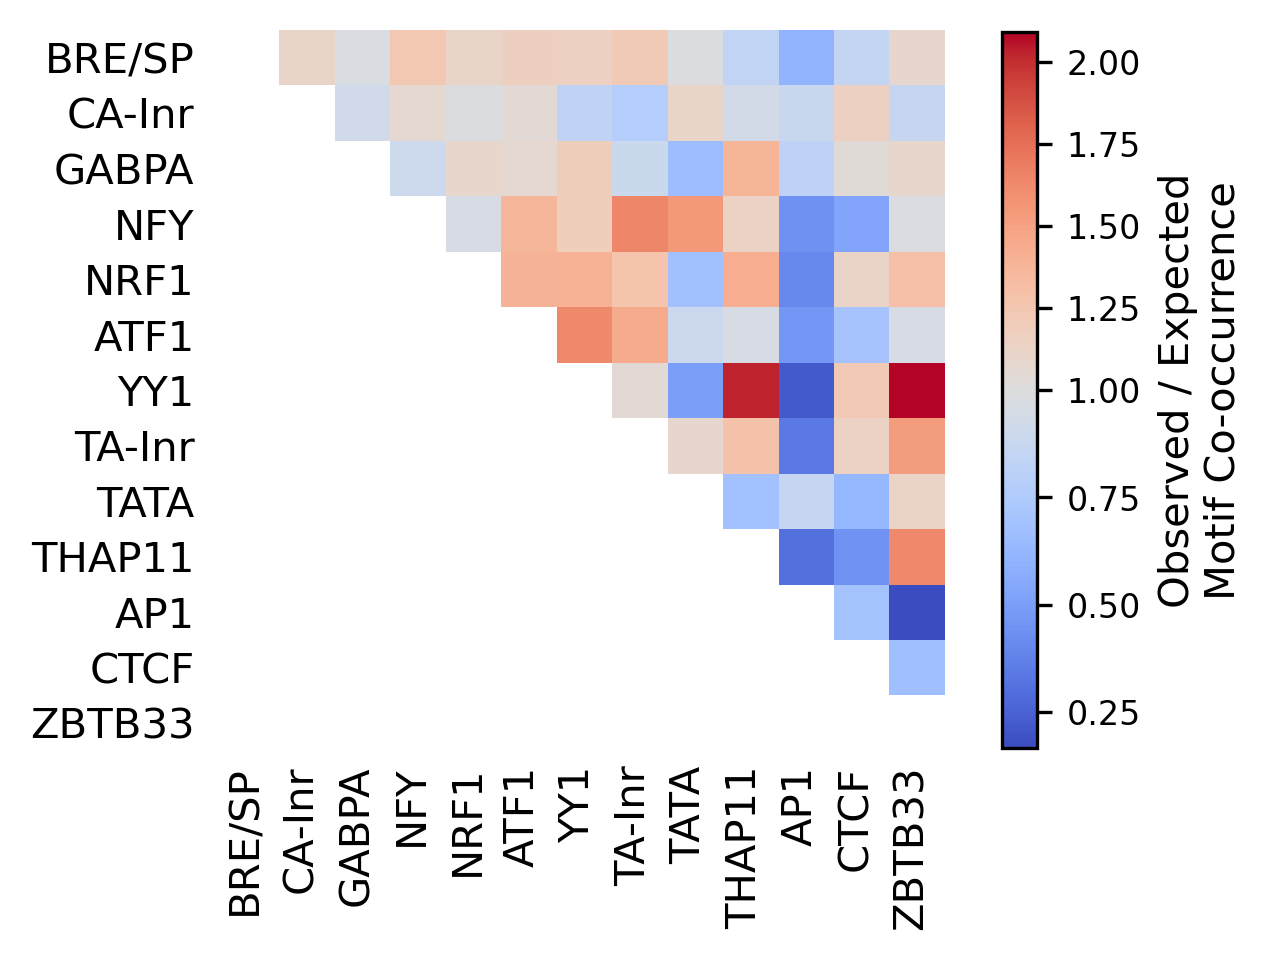

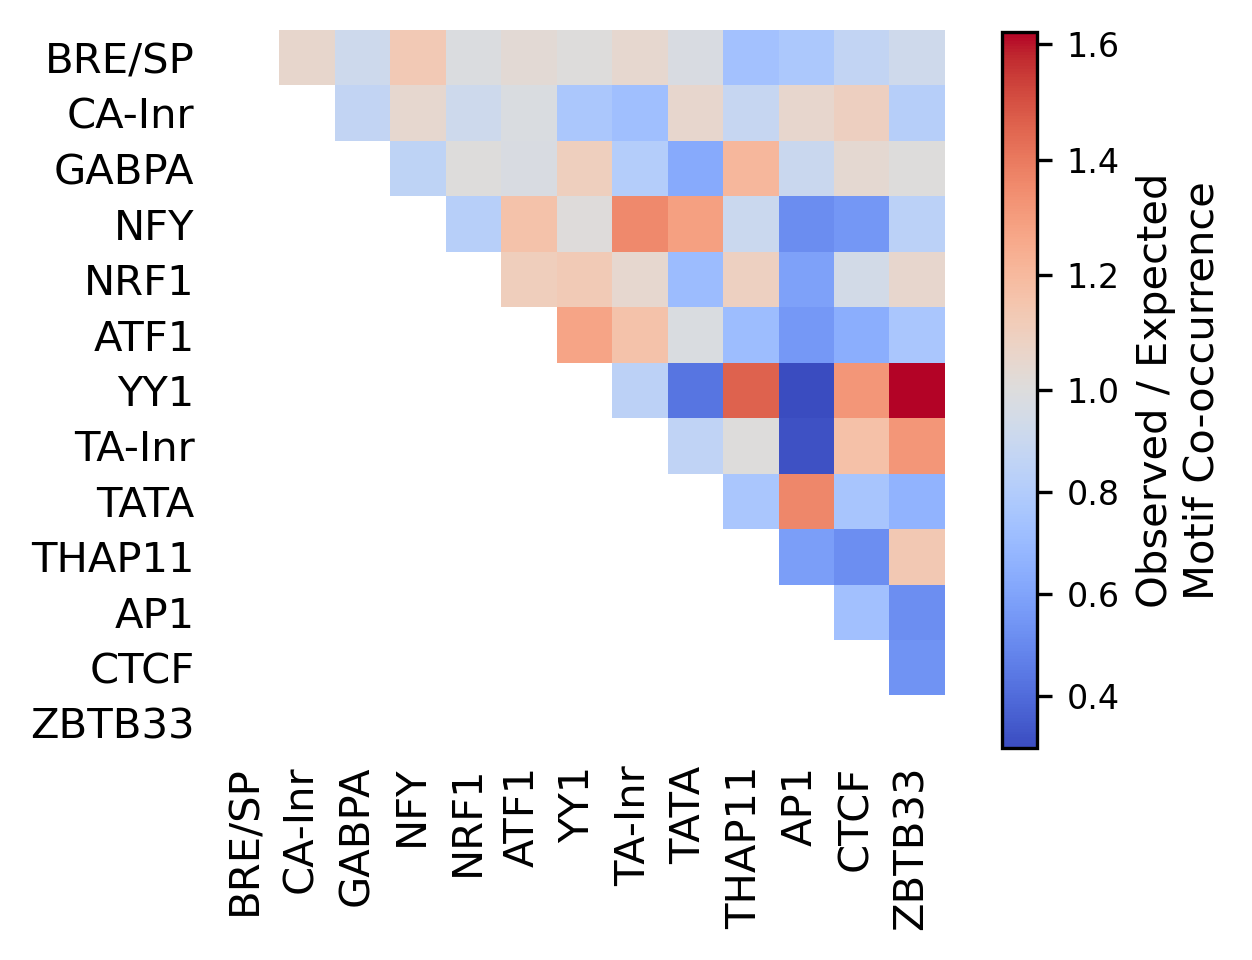

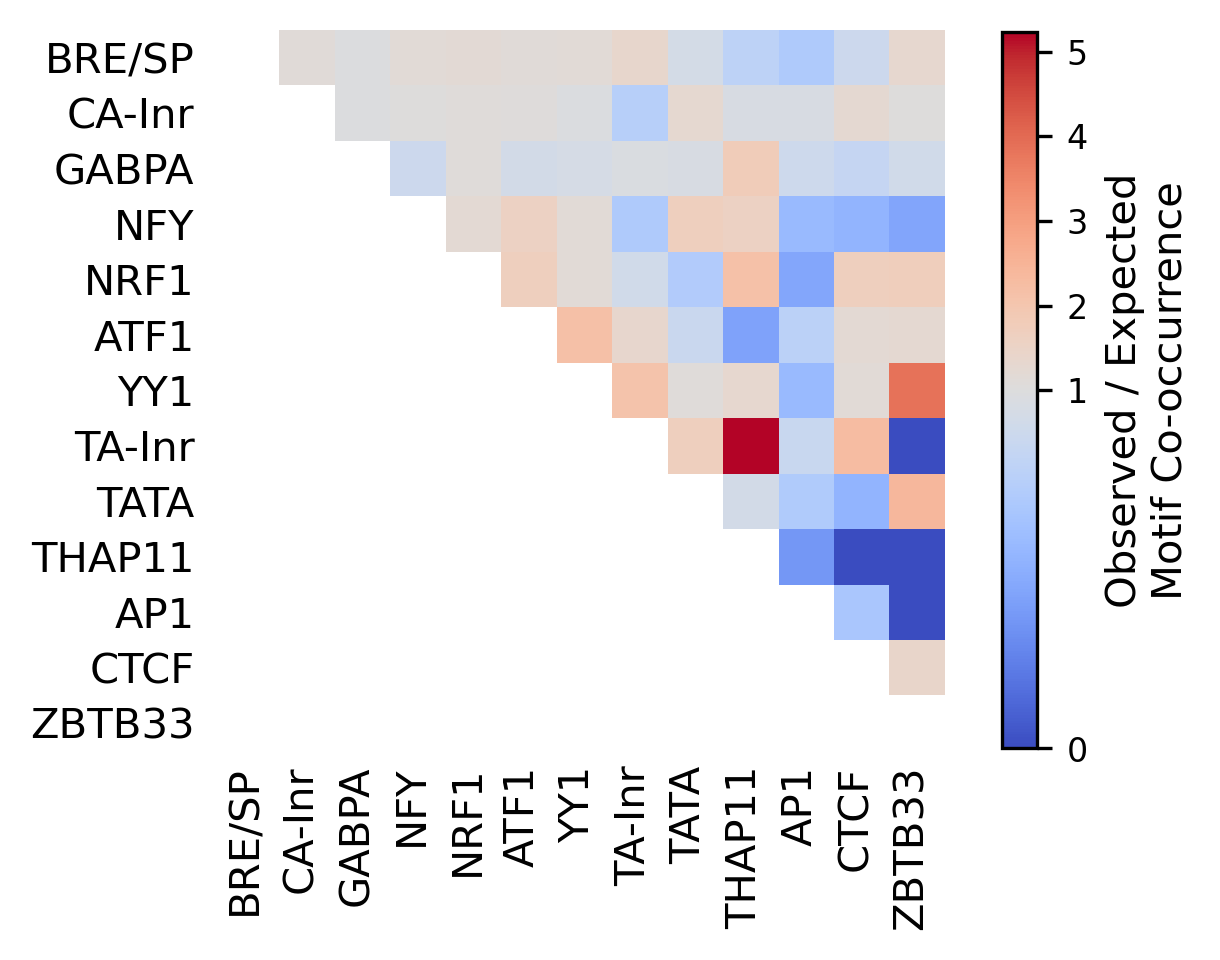

In [155]:
from collections import defaultdict
from matplotlib import colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix


def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  / peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :])

    motif_cooccur_enrichment = motif_cooccur_fracs / motif_frac_matrix
    
    combo_matrix = combine_two_symmetric_matrices(np.full_like(motif_frac_matrix, np.nan),
                                                  motif_cooccur_enrichment)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=np.min(combo_matrix[~np.isnan(combo_matrix)]),
                                                                       vcenter=1.,
                                        vmax=np.max(combo_matrix[~np.isnan(combo_matrix)])))
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Observed / Expected\nMotif Co-occurrence",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"])
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["dELS"]])

/tmp/ipykernel_14713/1146164121.py:57: RuntimeWarning: divide by zero encountered in log10
  neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))


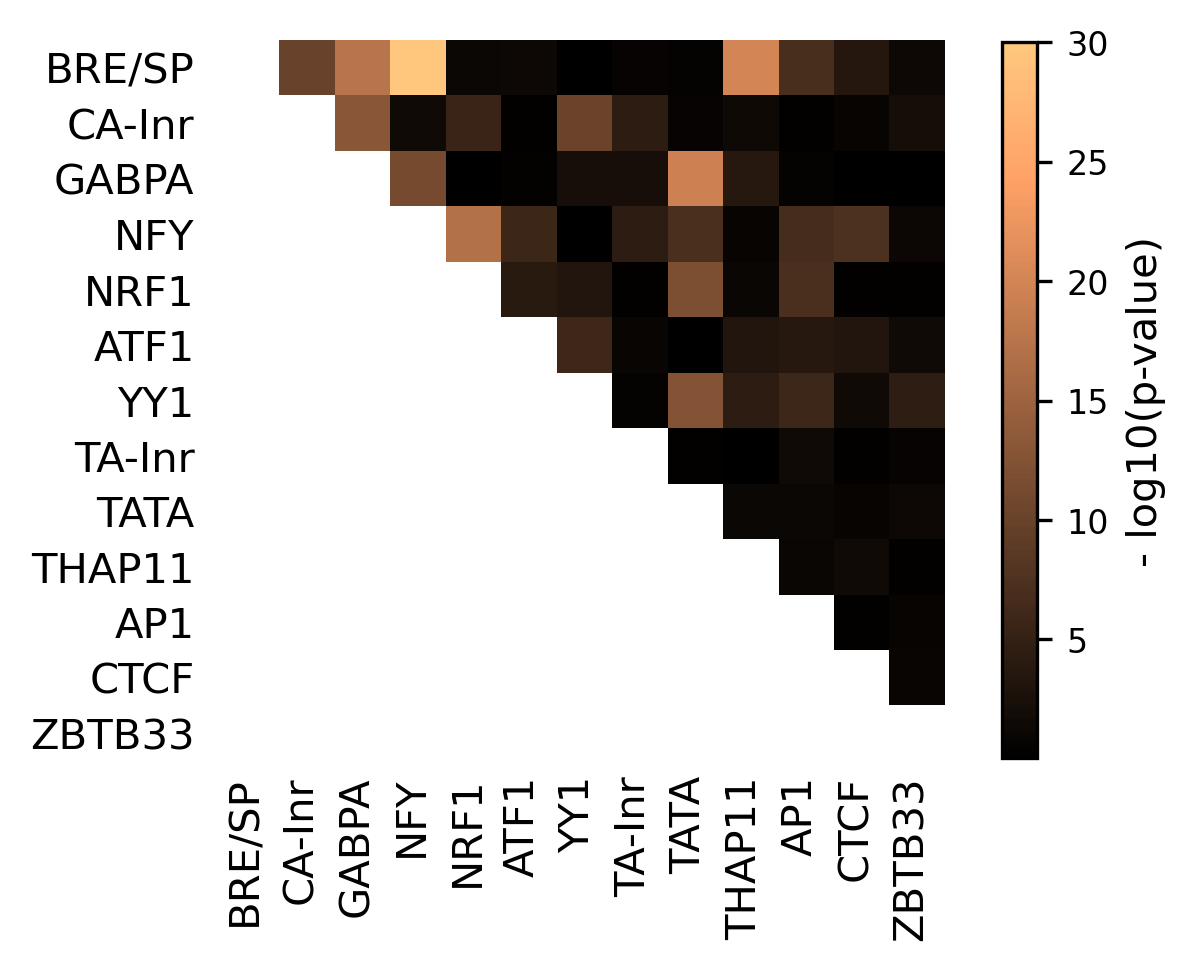

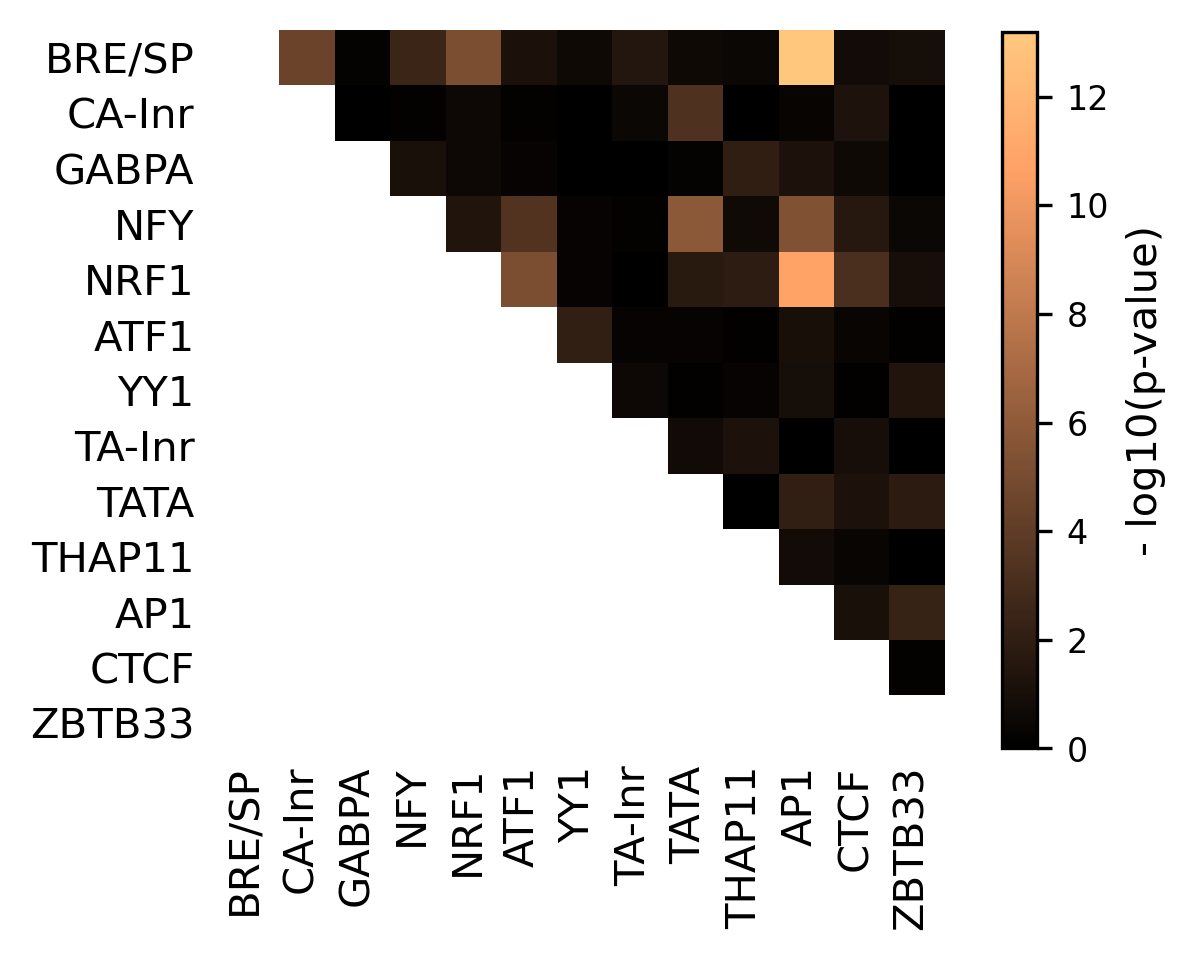

In [156]:
import scipy

def compute_cooccurrence_pvals(peak_hit_counts):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x M array of p-values for the M motifs.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_peaks, num_motifs = peak_hit_counts.shape
    
    pvals = np.ones((num_motifs, num_motifs))
    
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    for i in range(num_motifs):
        for j in range(i):
            pair_counts = peak_hit_indicators[:, [i, j]]
            peaks_with_1 = pair_counts[:, 0] == 1
            peaks_with_2 = pair_counts[:, 1] == 1
            # Contingency table (universe is set of all peaks):
            #              no motif 1  |  has motif 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    np.sum(~(peaks_with_1) & (~peaks_with_2)),
                    np.sum(peaks_with_1 & (~peaks_with_2))
                ],
                [
                    np.sum(~(peaks_with_1) & peaks_with_2),
                    np.sum(peaks_with_1 & peaks_with_2)
                ]
            ])
            pval = scipy.stats.fisher_exact(
                cont_table, alternative="two-sided"
            )[1]
            pvals[i, j] = pval
            pvals[j, i] = pval

        # Self-co-occurrence: Poissonize balls in bins
        # Expected number of collisions (via linearity of expectations):
        num_hits = np.sum(peak_hit_indicators[:, i])  # number of "balls"
        expected_collisions = num_hits * (num_hits - 1) / (2 * num_peaks)
        num_collisions = np.sum(peak_hit_counts[:, i] >= 2)
        pval = 1 - scipy.stats.poisson.cdf(num_collisions, mu=expected_collisions)
        pvals[i, i] = pval
    
    return pvals

def plot_pvals(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))
    
    #neg_log_pvals[neg_log_pvals < 5] = np.nan
    
    matrix_to_plot = combine_two_symmetric_matrices(np.full_like(neg_log_pvals, np.nan),
                                                    neg_log_pvals)
    
    num_motifs = len(motif_keys_to_labels)
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(matrix_to_plot, cmap="copper")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="- log10(p-value)",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    

plot_pvals(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_pvals(motif_hit_counts["profile"][ccre_annots["dELS"]])

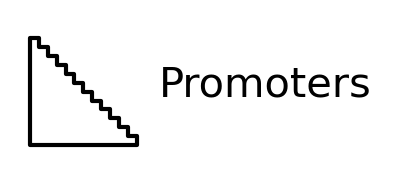

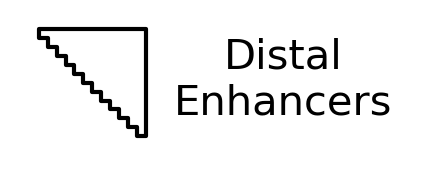

In [238]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def drew_legend_for_heatmap(combo_jaccard_matrix, promoters=True):
    dim = len(combo_jaccard_matrix)
    
    blank_map = np.full((dim, dim), np.nan)
    
    plt.figure(figsize=(0.5,0.5), dpi=300)
    cmap = get_continuous_cmap(["#3B1F68", "#5F31A6", "#B197DA"])  # doesn't matter
    cmap.set_bad('white',1.)
    plt.imshow(blank_map, cmap=cmap)
    
    ax = plt.gca()
    
    upper_right_highlight_coords = get_upper_right_highlight_coords(dim)
    if promoters:
        upper_right_highlight_coords = upper_right_highlight_coords[:, ::-1]
    upper_right_highlight = Polygon(upper_right_highlight_coords)
    ax.add_collection(PatchCollection([upper_right_highlight],
                                      color="k", facecolor="none",
                                      linewidth=1, clip_on=False))
    
    if promoters:
        ax.text(dim * 2, dim -5,
                "Promoters",
                ha="center", va="bottom", color="k", fontsize=10)
    else:
        ax.text(dim * 2+2, dim - 3,
                "Distal\nEnhancers",
                ha="center", va="bottom", color="k", fontsize=10)
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
    
drew_legend_for_heatmap(combo_jaccard_matrix, promoters=True)
drew_legend_for_heatmap(combo_jaccard_matrix, promoters=False)